In [1]:
% matplotlib inline

In [216]:
from os.path import join

from skbio import TreeNode
from biom import load_table, Table

from ete3 import Tree, TextFace, TreeStyle
from qiime2 import Artifact

# Insertion-constrained phylogeny calculation

This notebook gives an example of insertion-constrained phylogenetic tree insertion for 16S microbial sequences. 

The motivation for microbial tree estimation using constraints derived from phylogenetic insertion is to be able to create a tree of microbial 16S sequence fragments which both 1) conforms to the higher-level topology calculated from better data, and 2) retains as much information as possible about fine-level relationships among sequences. 

This is particularly relevant to problems involving host-microbe association, as it is frequently the case that reference databases will contain a few sequences close to a group of newly-observed host-associated microbes, but not enough to reflect the total amount of host-related diversity within the clade. Consequently, newly-observed sequences will all be inserted with long branches into the same edge on the reference phylogeny.

## Example data and visualization

We'll use a small set of OTUs from a recent publication on host-associated microbes [(Amato *et al.* 2017, *ISMEJ*)](https://www.nature.com/articles/s41396-018-0175-0) to illustrate this phenomenon, and to test our method. 

In [3]:
data_dir = './phylogeny_constraint/data'
output_dir = './phylogeny_constraint/output'

In [4]:
test_otu_fp =join(data_dir, 'test_otus.fasta')
test_otu_tree_fp = join(data_dir, 'test_otus.tre')

In [5]:
!head {test_otu_fp}

>denovo0
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATGTCGGGGCTCAACCCCGGAACTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo1
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTTAACTCCGGGGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo10
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAAACAGGTCAGATGTGAAAGCTCGGGGCTCAACCCCGGAACTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo2
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTCAACTCCGGAGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo3
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTTAACCCCGGGGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG


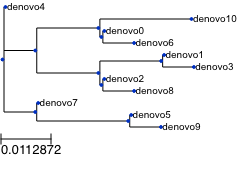

In [6]:
test_otu_tree = Tree(test_otu_tree_fp)

test_otu_tree.render("%%inline")

Now, we'll color these tips by the predominant host group in which they're found.

In [63]:
def highlight_tree(tree, leaf_colors):

    for node in tree.traverse():
        # Hide node circles
        node.img_style['size'] = 0
        if node.is_leaf():
            color = leaf_colors.get(node.name, None)
            if color:
                name_face = TextFace(node.name, fgcolor=color, fsize=10)
                node.add_face(name_face, column=0, position='branch-right')


    ts = TreeStyle()
    # ts.scale = 10
    # Disable the default tip names config
    ts.show_leaf_name = False
    ts.show_scale = False
    # Draw Tree
    return(tree.render('%%inline',  tree_style=ts))

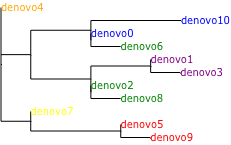

In [64]:
test_otu_tree = Tree(test_otu_tree_fp)

leaf_colors = {'denovo4': 'orange',
              'denovo7': 'yellow',
              'denovo9': 'red',
              'denovo5': 'red',
              'denovo3': 'purple',
              'denovo1': 'purple',
              'denovo8': 'green',
              'denovo2': 'green',
              'denovo10': 'blue',
              'denovo0': 'blue',
              'denovo6': 'green'}

highlight_tree(test_otu_tree, leaf_colors)

Searching these squences against GreenGenes reveals only two hits, which group the two major clades, but fail to resolve any of the variation within clades.

In [41]:
!vsearch --usearch_global {test_otu_fp} --db {data_dir}/97_otus.fasta.gz --id 0.97 --top_hits_only --blast6out -

vsearch v2.7.0_macos_x86_64, 8.0GB RAM, 4 cores
https://github.com/torognes/vsearch

Reading file ./phylogeny_constraint/data/97_otus.fasta.gz 100%                                                                            
142290491 nt in 99322 seqs, min 1254, max 2353, avg 1433
Masking 100%                                                                                                                                                                                                                                                                                                                                                                                                                
Counting k-mers 100%                                      
Creating k-mer index 100%                                                                                                                                                                                                                              

We'll try inserting these into the GG phylogeny and see what we get out

In [36]:
test_otu_artifact_fp = join(data_dir, 'test_sequences.qza')

In [37]:
!qiime tools import --type FeatureData[Sequence] \
--input-format DNAFASTAFormat \
--input-path ./phylogeny_constraint/data/test_otus.fasta \
--output-path {test_otu_artifact_fp}

Imported ./phylogeny_constraint/data/test_otus.fasta as DNAFASTAFormat to ./phylogeny_constraint/data/test_sequences.qza


In [10]:
test_insertion_fp = join(data_dir, 'test_sequences.sepp.tre.qza')
test_placement_fp = join(data_dir, 'test_sequences.sepp.json.qza')

In [41]:
!qiime fragment-insertion sepp \
--i-representative-sequences ./phylogeny_constraint/data/test_sequences.qza \
--o-tree {test_insertion_fp} --o-placements {test_placement_fp}

Saved Phylogeny[Rooted] to: ./phylogeny_constraint/data/test_sequences.sepp.tre.qza
Saved Placements to: ./phylogeny_constraint/data/test_sequences.sepp.json.qza


In [42]:
test_insertion_newick_fp = join(data_dir, 'test_sequences.sepp.tre')

In [43]:
!ls -l ./phylogeny_constraint/data

total 85280
-rw-r--r--+ 1 jonsanders  staff  29668455 Oct  1 13:28 97_otus.fasta.gz
-rw-r--r--  1 jonsanders  staff      1360 Oct  1 15:37 real_test
-rw-r--r--  1 jonsanders  staff      1360 Oct  1 15:38 real_test.fna
-rw-r--r--+ 1 jonsanders  staff      1761 Oct  1 16:25 test_otus.fasta
-rw-r--r--+ 1 jonsanders  staff       376 Oct  1 14:07 test_otus.tre
-rw-r--r--+ 1 jonsanders  staff      4062 Oct  1 16:25 test_sequences.qza
-rw-r--r--+ 1 jonsanders  staff   5471799 Oct  1 16:36 test_sequences.sepp.json.qza
-rw-r--r--  1 jonsanders  staff   6084620 Oct  1 16:13 test_sequences.sepp.tre
-rw-r--r--+ 1 jonsanders  staff   2408484 Oct  1 16:36 test_sequences.sepp.tre.qza


In [44]:
foofp = './phylogeny_constraint/data/test_sequences.qza'

In [45]:
!qiime tools export --input-path {foofp} \
--output-path test.fna \
--output-format DNAFASTAFormat

Exported ./phylogeny_constraint/data/test_sequences.qza as DNAFASTAFormat to file test.fna


In [46]:
!head test.fna

>denovo0
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATGTCGGGGCTCAACCCCGGAACTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo1
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTTAACTCCGGGGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo10
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAAACAGGTCAGATGTGAAAGCTCGGGGCTCAACCCCGGAACTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo2
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTCAACTCCGGAGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo3
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTTAACCCCGGGGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG


In [47]:
!qiime tools export --input-path {test_insertion_fp} \
--output-path {test_insertion_newick_fp} \
--output-format NewickFormat

Exported ./phylogeny_constraint/data/test_sequences.sepp.tre.qza as NewickFormat to file ./phylogeny_constraint/data/test_sequences.sepp.tre


In [48]:
# Importing newick tree

In [49]:
insert_tree = TreeNode.read(test_insertion_newick_fp)

In [54]:
inserted_subtree = insert_tree.lca(leaf_colors.keys())

In [57]:
inserted_subtree_fp = join(data_dir, 'test_sequences.sepp.subtree.tre')

inserted_subtree.write(inserted_subtree_fp)

'./phylogeny_constraint/data/test_sequences.sepp.subtree.tre'

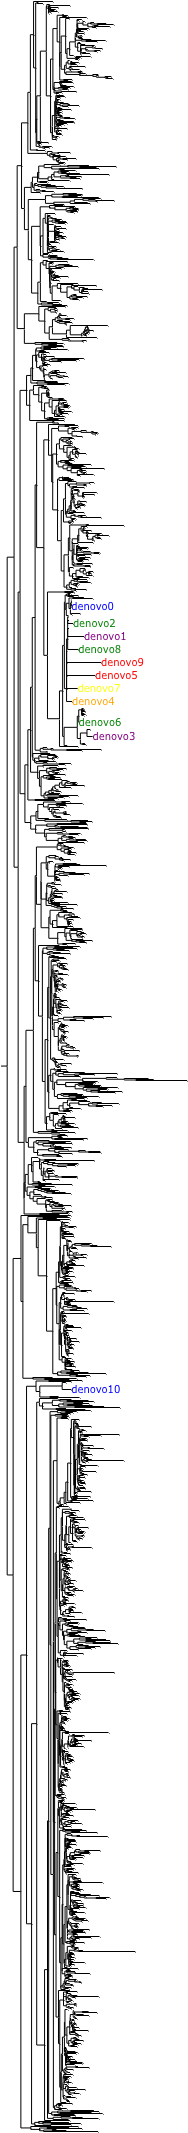

In [65]:
highlight_tree(Tree(inserted_subtree_fp), leaf_colors)

If we trim this down to just the tips we inserted, we can see how much of the internal structure has been removed in the insertion process:

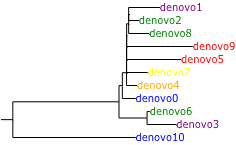

In [68]:
subtree_only = inserted_subtree.shear(leaf_colors.keys())

subtree_only_fp = join(data_dir, 'test_sequences.sepp.subtree.only.tre')

subtree_only.write(subtree_only_fp)

highlight_tree(Tree(subtree_only_fp), leaf_colors)

In [69]:
!head {subtree_only_fp}

(((((((((denovo1:0.0221287,denovo2:0.00726798):0.0,denovo8:0.0146221):0.00141544,denovo9:0.0468179):8.8363e-06,denovo5:0.0386087):3.97512e-05,denovo7:0.0149922):1.05796e-05,denovo4:0.007454):0.00299102,denovo0:0.00947843352):0.00235144,(denovo6:0.00197690352,denovo3:0.020793730000000003):0.01984514):0.07509018,denovo10:0.08689025):0.00837201;


## Collapse nodes in insertion tree

The sheared insertion tree is still bifurcating, even if many of the branches are meaningless. We'll write some code to collapse the nodes of the tree up to a given width. 

In [190]:
test_nwk = ('(((((((((denovo1:0.0221287,denovo2:0.00726798):0.0,denovo8:0.0146221)'
            ':0.00141544,denovo9:0.0468179):8.8363e-06,denovo5:0.0386087):3.97512e'
            '-05,denovo7:0.0149922):1.05796e-05,denovo4:0.007454):0.00299102,denov'
            'o0:0.00947843352):0.00235144,(denovo6:0.00197690352,denovo3:0.0207937'
            '30000000003):0.01984514):0.07509018,denovo10:0.08689025):0.00837201;\n')

exp_nwk = ('((denovo1:0.0,denovo2:0.0,denovo8:0.0,denovo9:0.0,denovo5:0.0,denovo7:0.0'
           ',denovo4:0.0,denovo0:0.0,denovo6:0.0,denovo3:0.0):0.07509018,denovo10:0.08'
           '689025):0.00837201;\n')

from io import StringIO

test_tree = TreeNode.read(StringIO(test_nwk))
exp_tree = TreeNode.read(StringIO(exp_nwk))

def collapse_nodes_to_width(in_tree, max_width=0.1, inplace=False):
    tree = in_tree.copy()
    for node in tree.postorder():
        node.width = node.get_max_distance()[0]
        
    for node in tree.postorder():
        if node.width < max_width:
            children = [x for x in node.tips()]
            for x in children:
                x.length = 0.
            node.children = children
    
    return(tree)

obs_tree = collapse_nodes_to_width(test_tree, max_width=0.1)
assert(obs_tree.write(StringIO()).getvalue() == exp_nwk)


exp_nwk_nolen = ('((denovo1,denovo2,denovo8,denovo9,denovo5,denovo7'
                 ',denovo4,denovo0,denovo6,denovo3),denovo10);\n')

def remove_branch_lengths(in_tree):
    tree = in_tree.copy()
    for node in tree.postorder():
        node.length = None
    return(tree)

obs_tree_nolen = remove_branch_lengths(exp_tree)

assert(obs_tree_nolen.write(StringIO()).getvalue() == exp_nwk_nolen)

## Run IQ-TREE with constraints

In [205]:
obs_constraint_fp = join(data_dir, 'test_sequences.sepp.subtree.only.constraint.tre')
obs_tree_nolen.write(obs_constraint_fp)

'./phylogeny_constraint/data/test_sequences.sepp.subtree.only.constraint.tre'

In [194]:
test_otu_aln_fp = join(data_dir, 'test_otus.aln.fasta')

In [214]:
%%capture
# mafft align sequences

!mafft {test_otu_fp} > {test_otu_aln_fp}

In [215]:
%%capture

# run IQ-TREE with constraints
!iqtree -nt 1 -s ./phylogeny_constraint/data/test_otus.aln.fasta \
-m TIM2+I+G -g ./phylogeny_constraint/data/test_sequences.sepp.subtree.only.constraint.tre \
-pre ./phylogeny_constraint/data/test_sequences.sepp.subtree.only.constrained

We can see that we have now recovered substantial structure within our group of sequences

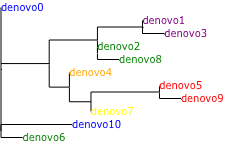

In [211]:
highlight_tree(Tree(join(data_dir, 'test_sequences.sepp.subtree.only.constrained.treefile')), leaf_colors)

## Test on larger data set

We'll load the complete dataset of deblurred sequences from the folivore study, and compare different ways of exploring them.

Load biom file of deblurred seqs

In [217]:
primates_biom_fp = join(data_dir, 'primates.deblur.biom')
primates_biom = load_table(primates_biom_fp)

Export seqs

In [227]:
primates_biom.metadata(axis='observation')[23]['taxonomy'][:1][-1]

'k__Bacteria'

In [230]:
primates_seqs = primates_biom.ids(axis='observation')

primates_seqs_fp = join(data_dir, 'primates.seqs.fna')

taxa_dict = {}

with open(primates_seqs_fp, 'w') as f:
    for i, s in enumerate(primates_seqs):
        taxa_dict[s] = primates_biom.metadata(axis='observation')[i]['taxonomy'][:2][-1]
        f.write('>{0}\n{0}\n'.format(s))


Align with mafft, make de novo tree with iq-tree

In [194]:
primate_aln_fp = join(data_dir, 'primates.seqs.aln.fasta')

In [214]:
# %%capture
# mafft align sequences

!mafft {primates_seqs_fp} > {primate_aln_fp}

In [215]:
# %%capture
# run IQ-TREE with constraints

!iqtree -nt 3 -s {primate_aln_fp} \
-m TIM2+I+G \
-pre ./phylogeny_constraint/data/primates.seqs.aln.denovo

make insertion tree with SEPP

In [232]:
primates_seqs_art_fp = join(data_dir, 'primates.seqs.fna.qza')

In [233]:
!qiime tools import --type FeatureData[Sequence] \
--input-format DNAFASTAFormat \
--input-path {primates_seqs_fp} \
--output-path {primates_seqs_art_fp}

Imported ./phylogeny_constraint/data/primates.seqs.fna as DNAFASTAFormat to ./phylogeny_constraint/data/primates.seqs.fna.qza


In [234]:
primate_insertion_fp = join(data_dir, 'primates.sepp.tre.qza')
primate_placement_fp = join(data_dir, 'primates.sepp.json.qza')

In [ ]:
!qiime fragment-insertion sepp \
--i-representative-sequences {primates_seqs_art_fp} \
--o-tree {primate_insertion_fp} --o-placements {primate_placement_fp}

show de novo tree and color by assigned phylum

show filtered insertion tree and color by assigned phylum

make constraint tree and rerun with constrained IQ-TREE

show filtered constrained de novo tree

grab some specific codiversifying clades and see how they fared in each 